In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import re
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications

from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
#veri seti yolu
path = "/content/drive/MyDrive/cicekler"

In [3]:
categories= [i.split('/')[-1]for i in [x[0] for x in os.walk(path)][1:]]
print(categories)

['Papatya', 'Lale', 'Süsen', 'Gül', 'Karahindiba', 'Ayçiçeği']


In [4]:
# Boş bir özellik listesi oluştur
features = []

# Hedef boyutu belirle
image_size = (224, 224)

# Kategori listesinde dolaş
for category in categories:
    # Kategori dizinini oluştur
    category_path = os.path.join(path, category)

    # Kategorinin indeksini al
    class_index = categories.index(category)

    # Kategori dizinindeki her bir görüntü dosyası için döngü
    for image_file in os.listdir(category_path):
        # Dosya ".jpg" uzantılıysa işlem yap
        if image_file.endswith('.jpg'):
            # Görüntü dosyasının tam yolunu oluştur
            image_path = os.path.join(category_path, image_file)

            # Görüntüyü Pillow kütüphanesi ile yükle ve renkli hale getir
            img = Image.open(image_path).convert('RGB')

            # Görüntüyü belirlenen boyuta yeniden boyutlandır
            img = img.resize(image_size)

            # Görüntüyü Numpy dizisine dönüştür ve özellik listesine ekle
            img_array = np.array(img)
            features.append([img_array, class_index])

# X ve y listelerini oluştur
X = [feature[0] for feature in features]
y = [feature[1] for feature in features]


#### BAZI GÖRSEL DEĞERLERİMİZİ GÖRSELEŞTİRELİM

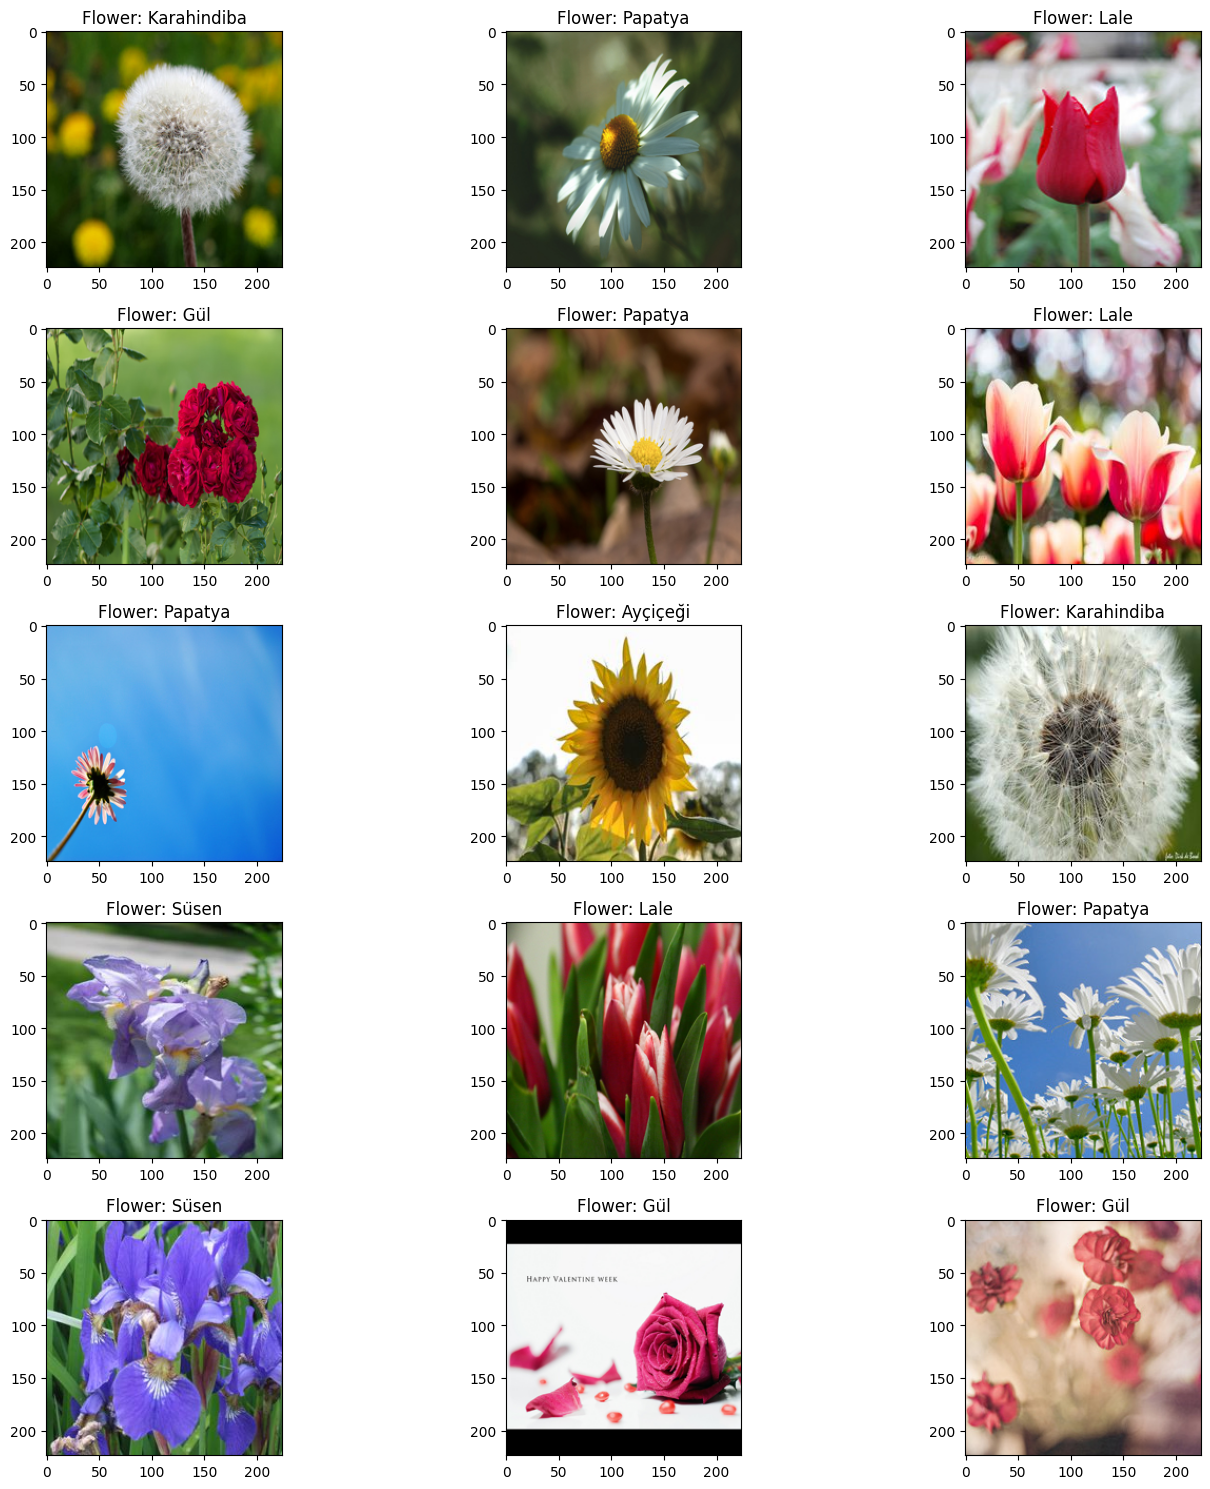

In [5]:
fig, ax = plt.subplots(5, 3)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(3):
        l = np.random.randint(0, len(y))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + categories[y[l]])
plt.tight_layout()
plt.show()

In [6]:
# Listeleri Numpy dizilerine dönüştür
X = np.array(X).astype('float32')
y = np.array(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
del X, y

In [8]:
print(f"Training set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")

Training set: 2699 images
Test set: 300 images


### CNN Model oluşturalım
##### Veri artırma tekniği ile mevcut veri setinden türetilen çeşitli dönüşümlerle yeni eğitim örnekleri oluşturarak modelin farklı varyasyonlara daha iyi perfonmas göstermesini sağlar

In [9]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),keras.layers.RandomRotation(factor=0.2),
                                      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                                      layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
                                      layers.RandomBrightness(factor=0.1),
                                      layers.RandomContrast(factor=0.1)])

CNN MODERLİ OLUŞTURALIM

In [10]:
# Giriş katmanı: 224x224 boyutunda
inputs = keras.Input(shape=(224, 224,3))
# Veri artırma katmanını uygula
x = data_augmentation(inputs)

# Piksel değerlerini [0, 255] aralığından [0, 1] aralığına normalize et
x = layers.Rescaling(1/255)(x)

# 1. Konvolüsyon katmanı: 256 filtre, 3x3 kernel, "same" padding, ReLU aktivasyon
x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
# Max pooling katmanı: 2x2 boyutunda havuzlama
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# Batch normalization katmanı
x = layers.BatchNormalization()(x)

# 2. Konvolüsyon katmanı
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

# 3. Konvolüsyon katmanı
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

# 4. Konvolüsyon katmanı
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

# 5. Konvolüsyon katmanı
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
# Dropout katmanı: Aşırı öğrenmeyi önlemek için %40 dropout uygula
x = layers.Dropout(0.4)(x)

# Global Average Pooling (GAP) katmanı: Her bir öznitelik haritasının ortalamasını alır
x = layers.GlobalAveragePooling2D()(x)
# Batch normalization katmanı
x = layers.BatchNormalization()(x)

# Çıkış katmanı: 6 sınıflı softmax aktivasyon
outputs = layers.Dense(6, activation="softmax")(x)

# Modeli oluştur
basic_model = keras.Model(inputs, outputs)


In [11]:
# Model özetini yazdır
basic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 256)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 256)     1024      
 Normalization)                                              

In [12]:
class GetBestModel(keras.callbacks.Callback):
    def __init__(self, monitor="val_loss", verbose=0, mode="auto"):
        """
        Keras Callback sınıfı ile en iyi modelin ağırlıklarını kaydetmek için özel bir sınıf.

        Argümanlar:
        - monitor: Takip edilecek ölçüm metriği (örneğin, "val_loss" veya "val_accuracy").
        - verbose: Gelişmeler hakkında bilgi yazdırmak için kullanılır (0: sessiz, 1: bilgili).
        - mode: "min" veya "max" olarak ayarlanan bir mod. Eğer "min" ise, en iyi model, monitor metriği en küçük olduğunda kaydedilir; eğer "max" ise, en büyük olduğunda kaydedilir.
        """
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        """
        Her epoch'un sonunda çağrılır. Mevcut epoch'taki belirtilen metrik değerini alır ve en iyi modeli günceller.
        """
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        """
        Eğitim tamamlandığında çağrılır. En iyi model ağırlıklarını, eğitim sırasında kaydedilen en iyi ağırlıklarla değiştirir.
        """
        self.model.set_weights(self.best_weights)


In [13]:
# En iyi modeli takip etmek için GetBestModel sınıfını oluştur
best_model = GetBestModel(monitor="val_loss", mode="min", verbose=1)

In [14]:
# Erken durdurma için EarlyStopping callback'i oluştur
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

In [15]:
# Modeli derle: Adam optimizer, sparse categorical crossentropy kayıp fonksiyonu, doğruluk metriği
# Eski Keras optimizer'ını kullanarak modeli derleme
basic_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                    loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [16]:
# Modeli eğit: X_train ve y_train verilerini kullanarak, 100 epoch boyunca eğitim yap
# Validation verisi olarak X_test ve y_test'i kullan
# Callback'ler olarak erken durdurma ve en iyi modeli kaydetme callback'lerini kullan
history = basic_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, best_model])

Epoch 1/100
 6/85 [=>............................] - ETA: 50s - loss: 1.7443 - accuracy: 0.3438

85/85 [==============================] - 75s 678ms/step - loss: 1.1594 - accuracy: 0.5706 - val_loss: 1.9300 - val_accuracy: 0.1667
Epoch 2/100
85/85 [==============================] - 54s 634ms/step - loss: 0.9629 - accuracy: 0.6606 - val_loss: 2.3699 - val_accuracy: 0.1667
Epoch 3/100
85/85 [==============================] - 54s 638ms/step - loss: 0.8759 - accuracy: 0.6903 - val_loss: 2.5207 - val_accuracy: 0.1667
Epoch 4/100
85/85 [==============================] - 54s 637ms/step - loss: 0.8472 - accuracy: 0.6999 - val_loss: 2.8700 - val_accuracy: 0.1667
Epoch 5/100
85/85 [==============================] - 54s 638ms/step - loss: 0.8218 - accuracy: 0.7021 - val_loss: 2.3601 - val_accuracy: 0.1767
Epoch 6/100
85/85 [==============================] - 54s 637ms/step - loss: 0.7902 - accuracy: 0.7195 - val_loss: 1.7665 - val_accuracy: 0.2900
Epoch 7/100
85/85 [==============================] - 54s 639ms/step - loss: 0.7412 - accuracy: 0.7447 - val_loss: 1.0993 - val_accuracy: 0.5400
Epoc

Eğitilmiş modelin test veri kümesi üzerinde performansını değerlendirelim


In [17]:
basic_model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 69ms/step - loss: 0.3683 - accuracy: 0.8867


[0.36830562353134155, 0.8866666555404663]

Eğitilmiş modelinizin hem eğitim setindeki hem de test setindeki performansını değerlendirelim

In [18]:
# Eğitim seti üzerinde tahminler yapma
train_proba = basic_model.predict(X_train)
train_prediction = np.argmax(train_proba, axis=1)

# Test seti üzerinde tahminler yapma
val_proba = basic_model.predict(X_test)
val_prediction = np.argmax(val_proba, axis=1)

# Test sonuçlarını yazdırma
print("TEST SONUÇLARI")
# Confusion Matrix'i yazdırma
print(confusion_matrix(y_test, val_prediction))
# Sınıflandırma raporunu yazdırma
print(classification_report(y_test, val_prediction))

# Ayraç
print("------------------------------")

# Eğitim sonuçlarını yazdırma
print("EĞİTİM SONUÇLARI")
# Eğitim seti için Confusion Matrix'i yazdırma
print(confusion_matrix(y_train, train_prediction))
# Eğitim seti için sınıflandırma raporunu yazdırma
print(classification_report(y_train, train_prediction))


10/10 [==============================] - 1s 62ms/step
TEST SONUÇLARI
[[36  1  0  5  5  3]
 [ 1 44  1  3  0  1]
 [ 0  1 46  1  1  1]
 [ 1  3  3 43  0  0]
 [ 2  0  0  0 48  0]
 [ 1  0  0  0  0 49]]
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        50
           1       0.90      0.88      0.89        50
           2       0.92      0.92      0.92        50
           3       0.83      0.86      0.84        50
           4       0.89      0.96      0.92        50
           5       0.91      0.98      0.94        50

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.88       300
weighted avg       0.89      0.89      0.88       300

------------------------------
EĞİTİM SONUÇLARI
[[362  10   8  15  32  23]
 [  5 373  14  46   7   5]
 [  1   2 429  13   4   1]
 [ 16  28  23 365  12   6]
 [ 20   3   2  11 409   5]
 [  0   1   0   2   1 445]]
              precision    recall  f1-score   supp

Modelin eğitildikçe kaybının ve doğruluğunun nasıl değiştiğini görseleştirelim

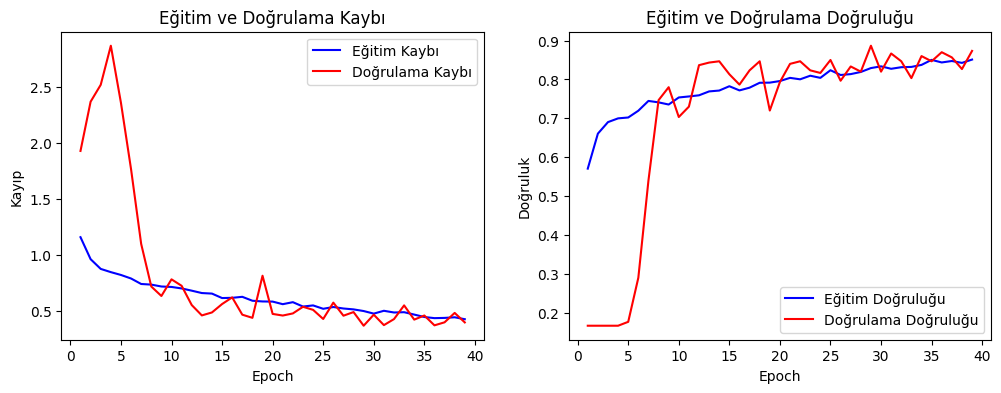

In [20]:
# Eğitim kaybı (loss) ve doğrulama (validation) kaybını elde etme
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim doğruluğu (accuracy) ve doğrulama doğruluğunu elde etme
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği çizimi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği çizimi
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Eğitim Doğruluğu')
plt.plot(epochs, val_accuracy, 'r', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Grafikleri gösterme
plt.show()


Modeli kaydedelim

In [21]:
basic_model.save('CNN_model_79.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
